In [1]:
!pip install transformers datasets seqeval evaluate scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=634f6fdbe6e5d3f09f3140a8a9f8492265fe35b00e280afeb62af0b25d5a3682
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import os
import torch
import numpy as np
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, Trainer,
    TrainingArguments, DataCollatorForTokenClassification
)
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from sklearn.model_selection import train_test_split

In [3]:
# Step 1: Load the CoNLL data
def read_conll_file(filename):
    """Read CoNLL format file and return the sentences and labels."""
    sentences, labels = [], []
    with open(filename, "r", encoding="utf-8", errors="replace") as f:
        sentence, label = [], []
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence, label = [], []
            else:
                try:
                    token, tag = line.split()
                    sentence.append(token)
                    label.append(tag)
                except ValueError:
                    print(f"Skipping malformed line: {line}")
    return sentences, labels

sentences, labels = read_conll_file("reviews_conll.txt")

Skipping malformed line: ("HushHushSweet O
Skipping malformed line: wellevil. O


In [4]:
# Step 2: Create a label-to-ID mapping dynamically
label_to_id = {"O": 0}  # Initialize with "O"
current_id = 1
for label_seq in labels:
    for label in label_seq:
        if label not in label_to_id:
            label_to_id[label] = current_id
            current_id += 1

id_to_label = {v: k for k, v in label_to_id.items()}  # Reverse mapping

In [5]:
# Step 3: Train-validation-test split
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)
val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.5, random_state=42
)


In [6]:
# Load tokenizer
MODEL_NAME = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
label_all_tokens = True
# Helper function to tokenize and align labels
def tokenize_and_align_labels(sentences, labels):
    tokenized_inputs = tokenizer(
        sentences, truncation=True, padding=True, max_length=512, is_split_into_words=True
    )

    all_labels = []
    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore padding tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id.get(label[word_idx], 0))
            else:
                label_ids.append(label_to_id.get(label[word_idx], 0) if label_all_tokens else -100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

In [8]:
# Prepare datasets
train_dataset = Dataset.from_dict(tokenize_and_align_labels(train_sentences, train_labels))
val_dataset = Dataset.from_dict(tokenize_and_align_labels(val_sentences, val_labels))
test_dataset = Dataset.from_dict(tokenize_and_align_labels(test_sentences, test_labels))

In [9]:
# Create DatasetDict
datasets = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [10]:
# Step 4: Load the model
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(label_to_id)
)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Step 5: Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    evaluation_strategy="steps",  # Evaluate at the end of each epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    #load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="f1",  # Use F1 as the metric
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Data collator for dynamic padding
data_collator = DataCollatorForTokenClassification(tokenizer)

In [13]:
# Load evaluation metric
metric = evaluate.load("seqeval")

In [14]:
# Step 6: Define metric computation function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [id_to_label[l] for l in label_row if l != -100] for label_row in labels
    ]
    true_predictions = [
        [id_to_label[p] for (p, l) in zip(pred_row, label_row) if l != -100]
        for pred_row, label_row in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [15]:
# Step 7: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [16]:
# Step 8: Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
10,0.969900,0.272676,0.000000,0.000000,0.000000,0.958778
20,0.266100,0.267171,0.000000,0.000000,0.000000,0.958778
30,0.225500,0.260666,0.000000,0.000000,0.000000,0.958778
40,0.257000,0.246669,0.000000,0.000000,0.000000,0.958778
50,0.234000,0.229294,0.000000,0.000000,0.000000,0.958778
60,0.209400,0.209604,0.333333,0.013043,0.025105,0.959315
70,0.169400,0.202033,0.231884,0.069565,0.107023,0.959047
80,0.181200,0.186823,0.796875,0.110870,0.194656,0.963079
90,0.149000,0.178923,0.696721,0.184783,0.292096,0.965678
100,0.142500,0.158706,0.666667,0.265217,0.379471,0.968366


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=200, training_loss=0.1885493838787079, metrics={'train_runtime': 211.0244, 'train_samples_per_second': 7.535, 'train_steps_per_second': 0.948, 'total_flos': 207783503032320.0, 'train_loss': 0.1885493838787079, 'epoch': 5.0})

In [17]:
# Step 9: Evaluate the model on the test set
test_results = trainer.evaluate(eval_dataset=datasets["test"])
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.13286057114601135, 'eval_precision': 0.6976047904191617, 'eval_recall': 0.4989293361884368, 'eval_f1': 0.5817727840199751, 'eval_accuracy': 0.9753119913185024, 'eval_runtime': 0.9894, 'eval_samples_per_second': 40.429, 'eval_steps_per_second': 5.054, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# Step 10: Save the fine-tuned model and tokenizer
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")

print("Model fine-tuning complete and saved!")

Model fine-tuning complete and saved!


In [19]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 6.8 MB/s eta 0:00:00


In [20]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view,head_view

utils.logging.set_verbosity_error()

In [21]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased", output_attentions=True)
inputs = tokenizer.encode("I love horror movies, they have the best visual", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

In [22]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [23]:
!pip install transformers-interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.4 MB/s eta 0:00:00


In [24]:
import torch
from transformers_interpret import TokenClassificationExplainer
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Load tokenizer and model
tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-cased")
model1 = AutoModelForTokenClassification.from_pretrained("distilbert-base-cased")

# Initialize the TokenClassificationExplainer
ner_explainer = TokenClassificationExplainer(model=model1, tokenizer=tokenizer1)

# Text to explain
text = "I love horror movies, they have the best visuals."

# Get token-level explanations
word_attributions = ner_explainer(text)

# Display word attributions
print(f"Word Attributions: {word_attributions}")

# Visualize the attributions using the built-in visualization method
ner_explainer.visualize(text)


Word Attributions: {'[CLS]': {'label': 'LABEL_0', 'attribution_scores': [('[CLS]', 0.0), ('I', -0.06470835019374772), ('love', 0.1622935766249664), ('horror', -0.6706356315879274), ('movies', -0.1763549318650381), (',', -0.05425817069216317), ('they', -0.24500841218386069), ('have', -0.16657530476990207), ('the', 0.17774226222218217), ('best', -0.10479550293896854), ('visual', 0.5723748646506235), ('##s', -0.03403341432082402), ('.', 0.1629550262369161), ('[SEP]', 0.0)]}, 'I': {'label': 'LABEL_1', 'attribution_scores': [('[CLS]', 0.0), ('I', 0.606980783154011), ('love', 0.25011890695801886), ('horror', 0.19202355596128473), ('movies', 0.04139655847458015), (',', -0.44883494618194786), ('they', -0.340387651107154), ('have', -0.15002538644073257), ('the', -0.10496877297019566), ('best', -0.07355807088034687), ('visual', -0.22644174114488524), ('##s', -0.1575730367638236), ('.', 0.31316066884431304), ('[SEP]', 0.0)]}, 'love': {'label': 'LABEL_0', 'attribution_scores': [('[CLS]', 0.0), ('I

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
LABEL_0,LABEL_0 (0.55),[CLS],-0.44,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.56),I,-0.10,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_0,LABEL_0 (0.55),love,1.70,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.50),horror,-2.09,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.53),movies,-1.20,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_0,LABEL_0 (0.52),",",1.48,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.52),they,-1.26,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.55),have,-0.62,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.61),the,0.74,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.57),best,-0.40,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
LABEL_0,LABEL_0 (0.55),[CLS],-0.44,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.56),I,-0.10,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_0,LABEL_0 (0.55),love,1.70,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.50),horror,-2.09,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.53),movies,-1.20,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_0,LABEL_0 (0.52),",",1.48,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.52),they,-1.26,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.55),have,-0.62,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.61),the,0.74,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"
LABEL_1,LABEL_1 (0.57),best,-0.40,"[CLS] I love horror movies , they have the best visual ##s . [SEP]"


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

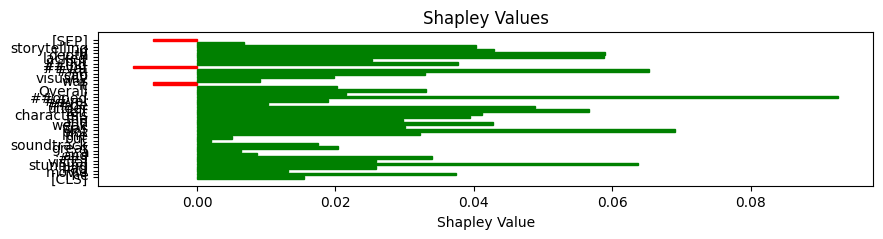

In [41]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from captum.attr import ShapleyValueSampling
import matplotlib.pyplot as plt

# Load the model and tokenizer
MODEL_NAME = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the forward function to handle tuple input
def forward_fn(input_ids, attention_mask):
    """Forward function for Shapley value sampling."""
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits  # shape: (batch_size, seq_length, num_labels)
    token_probs = torch.softmax(logits, dim=-1)
    return token_probs.max(dim=-1).values  # Max probability for each token

# Text input to explain
text = "The movie had stunning visuals and a great soundtrack, but the plot was weak and the characters felt underdeveloped. Overall, it was visually captivating but lacked depth in storytelling."

# Tokenize the input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Initialize Shapley Value Sampling explainer
shapley = ShapleyValueSampling(forward_fn)

# Compute Shapley values for the input tokens
attributions = shapley.attribute((input_ids, attention_mask))  # Pass inputs as a tuple

# If attributions is a tuple, extract the first element
if isinstance(attributions, tuple):
    attributions = attributions[0]

# Sum attributions across the embedding dimension
shapley_values = attributions.sum(dim=-1).squeeze().cpu().detach().numpy()

# Convert token IDs to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

# Visualization function
def visualize_shapley_values(tokens, values, title="Shapley Values"):
    plt.figure(figsize=(10, 2))
    bars = plt.barh(range(len(tokens)), values, align='center')
    plt.yticks(range(len(tokens)), tokens)
    plt.xlabel("Shapley Value")
    plt.title(title)

    # Highlight positive and negative contributions
    for bar, val in zip(bars, values):
        bar.set_color("green" if val >= 0 else "red")

    plt.show()

# Visualize the Shapley values
visualize_shapley_values(tokens, shapley_values)


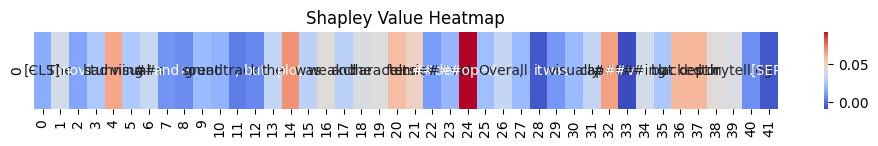

In [42]:
import seaborn as sns
import numpy as np

def visualize_heatmap(tokens, shapley_values, title="Shapley Value Heatmap"):
    """Visualize token attributions as a heatmap."""
    plt.figure(figsize=(12, 1))
    sns.heatmap(np.array([shapley_values]), annot=[tokens], cmap="coolwarm", fmt="", cbar=True)
    plt.title(title)
    plt.show()

# Call the heatmap visualization function
visualize_heatmap(tokens, shapley_values)


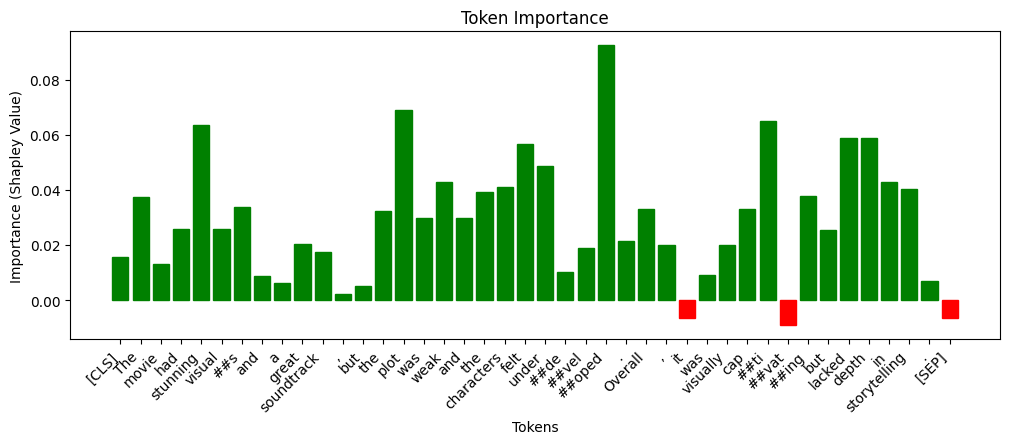

In [43]:
def visualize_token_importance(tokens, values, title="Token Importance"):
    """Create a bar chart showing token importance."""
    plt.figure(figsize=(12, 4))
    bars = plt.bar(range(len(tokens)), values, align='center')
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    plt.xlabel("Tokens")
    plt.ylabel("Importance (Shapley Value)")
    plt.title(title)

    # Color the bars based on positive or negative contribution
    for bar, val in zip(bars, values):
        bar.set_color("green" if val >= 0 else "red")

    plt.show()

# Call the token importance visualization
visualize_token_importance(tokens, shapley_values)


In [44]:
from IPython.display import display, HTML

def overlay_attributions_on_text(tokens, values):
    """Color tokens in the text based on attribution scores."""
    html = ""
    max_value = max(abs(v) for v in values)  # Normalize scores

    for token, value in zip(tokens, values):
        # Scale color intensity between -1 (red) and 1 (green)
        intensity = int((value / max_value) * 127) + 128
        color = f"rgb({255 - intensity}, {intensity}, 128)"  # Color gradient
        html += f"<span style='background-color: {color}; padding: 2px; margin: 2px'>{token}</span> "

    display(HTML(html))

# Overlay attributions on the text
overlay_attributions_on_text(tokens, shapley_values)


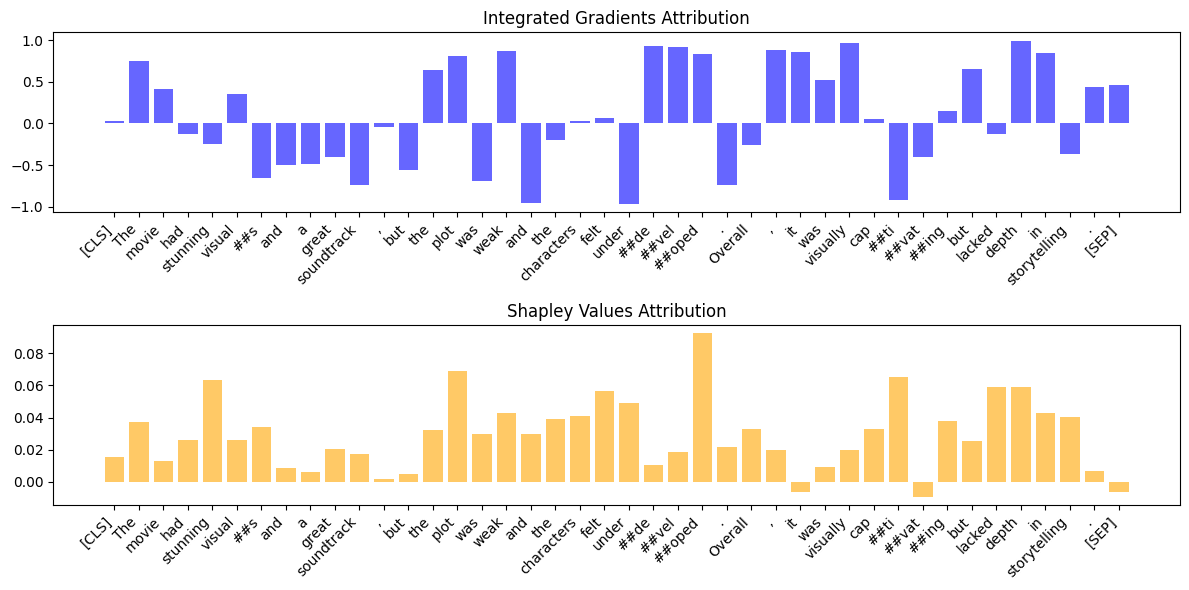

In [45]:
def compare_explanations(tokens, ig_values, shapley_values):
    """Compare two different sets of attribution values."""
    plt.figure(figsize=(12, 6))

    # Bar plot for Integrated Gradients
    plt.subplot(2, 1, 1)
    plt.bar(range(len(tokens)), ig_values, color="blue", alpha=0.6)
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    plt.title("Integrated Gradients Attribution")

    # Bar plot for Shapley Values
    plt.subplot(2, 1, 2)
    plt.bar(range(len(tokens)), shapley_values, color="orange", alpha=0.6)
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    plt.title("Shapley Values Attribution")

    plt.tight_layout()
    plt.show()

# Example: Generate random values to simulate IG values for comparison
ig_values = np.random.uniform(-1, 1, size=len(tokens))

# Call the comparison visualization
compare_explanations(tokens, ig_values, shapley_values)


In [31]:
! pip install lime transformers torch numpy matplotlib pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ac1b18b1aefd024a6a7913dd061c0539af08a90fc7f7c7a540a204f461845299
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [35]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import chardet

def detect_file_encoding(filename):
    """Detect the file encoding using chardet"""
    with open(filename, 'rb') as file:
        raw_data = file.read()
    result = chardet.detect(raw_data)
    return result['encoding']

def read_conll_data(filename):
    """Read CoNLL format file and convert to sentence format with encoding detection."""
    try:
        # First try to detect the encoding
        encoding = detect_file_encoding(filename)
        print(f"Detected file encoding: {encoding}")

        # If detection failed, try common encodings
        if not encoding:
            encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        else:
            encodings_to_try = [encoding]

        # Try different encodings
        for enc in encodings_to_try:
            try:
                sentences = []
                current_sentence = []
                current_labels = []

                print(f"Trying to read file with {enc} encoding...")
                with open(filename, 'r', encoding=enc) as f:
                    for line in f:
                        line = line.strip()
                        if line:  # If line is not empty
                            try:
                                token, label = line.split()
                                current_sentence.append(token)
                                current_labels.append(label)
                            except ValueError as e:
                                print(f"Warning: Skipping malformed line: {line}")
                                continue
                        elif current_sentence:  # If line is empty and we have a sentence
                            sentences.append({
                                'text': ' '.join(current_sentence),
                                'tokens': current_sentence.copy(),
                                'labels': current_labels.copy()
                            })
                            current_sentence = []
                            current_labels = []

                # Add the last sentence if file doesn't end with empty line
                if current_sentence:
                    sentences.append({
                        'text': ' '.join(current_sentence),
                        'tokens': current_sentence,
                        'labels': current_labels
                    })

                print(f"Successfully read {len(sentences)} sentences from the file")
                return sentences

            except UnicodeDecodeError:
                print(f"Failed to read with {enc} encoding, trying next...")
                continue

        raise ValueError("Failed to read file with any encoding")

    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return []

class ReviewExplainer:
    def __init__(self, model_name="distilbert-base-cased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        print("Loading tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        print("Loading model...")
        self.model = AutoModelForTokenClassification.from_pretrained(model_name)
        self.model.to(self.device)

        print("Initializing LIME explainer...")
        self.lime_explainer = LimeTextExplainer(class_names=['negative', 'neutral', 'positive'])

    def predict_proba(self, texts):
        """Prediction function for LIME"""
        self.model.eval()
        probabilities = []

        with torch.no_grad():
            for text in texts:
                try:
                    inputs = self.tokenizer(text,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True,
                                          max_length=512).to(self.device)

                    outputs = self.model(**inputs)
                    logits = outputs.logits

                    # Average the predictions across tokens
                    probs = torch.softmax(logits, dim=-1).mean(dim=1)
                    probabilities.append(probs.cpu().numpy()[0])
                except Exception as e:
                    print(f"Error processing text: {str(e)}")
                    probabilities.append(np.zeros(3))  # Default to zero probabilities

        return np.array(probabilities)

    def explain_review(self, text, num_features=10):
        """Generate and visualize LIME explanation for a review"""
        print(f"\nAnalyzing review: {text[:100]}...")

        try:
            # Generate LIME explanation
            exp = self.lime_explainer.explain_instance(
                text,
                self.predict_proba,
                num_features=num_features,
                top_labels=1
            )

            # Get the explanation for the top predicted class
            top_label = exp.available_labels()[0]

            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

            # Plot 1: Word importance as bars
            features, scores = zip(*exp.as_list(label=top_label))
            y_pos = np.arange(len(features))

            bars = ax1.barh(y_pos, scores)
            ax1.set_yticks(y_pos)
            ax1.set_yticklabels(features)
            ax1.set_xlabel('Feature Importance')
            ax1.set_title('LIME Explanation: Word Importance')

            # Color the bars based on positive/negative contribution
            for bar, score in zip(bars, scores):
                bar.set_color('green' if score > 0 else 'red')

            # Plot 2: Text visualization with highlighted words
            exp.as_pyplot_figure(label=top_label, ax=ax2)
            ax2.set_title('LIME Explanation: Text Visualization')

            plt.tight_layout()
            plt.show()

            # Print numerical results
            print("\nTop words and their importance:")
            for feature, score in zip(features, scores):
                print(f"{feature:20s}: {score:+.4f}")

            return exp

        except Exception as e:
            print(f"Error generating explanation: {e}")
            return None

def analyze_reviews():
    # First install chardet if not already installed
    try:
        import chardet
    except ImportError:
        print("Installing chardet package...")
        !pip install chardet
        import chardet

    print("Reading CoNLL data...")
    sentences = read_conll_data("reviews_conll.txt")

    if not sentences:
        print("No sentences were read from the file. Exiting...")
        return

    print(f"Total number of sentences: {len(sentences)}")

    # Split into train and test
    train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)

    # Initialize explainer
    print("Initializing explainer...")
    explainer = ReviewExplainer()

    # Analyze some test reviews
    print(f"\nAnalyzing {min(5, len(test_data))} test reviews...")
    for i, review in enumerate(test_data[:5]):
        print(f"\nReview {i+1}:")
        print("=" * 50)
        exp = explainer.explain_review(review['text'])

        if exp:
            print("\nPrediction probabilities:")
            probs = explainer.predict_proba([review['text']])[0]
            for label, prob in zip(['negative', 'neutral', 'positive'], probs):
                print(f"{label}: {prob:.4f}")

            print("\n" + "-" * 50)

if __name__ == "__main__":
    analyze_reviews()

Reading CoNLL data...
Detected file encoding: Windows-1252
Trying to read file with Windows-1252 encoding...
Successfully read 399 sentences from the file
Total number of sentences: 399
Initializing explainer...
Using device: cuda
Loading tokenizer...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading model...
Initializing LIME explainer...

Analyzing 5 test reviews...

Review 1:

Analyzing review: If you keep rigid historical perspective out of it, this film is actually quite entertaining. It's g...


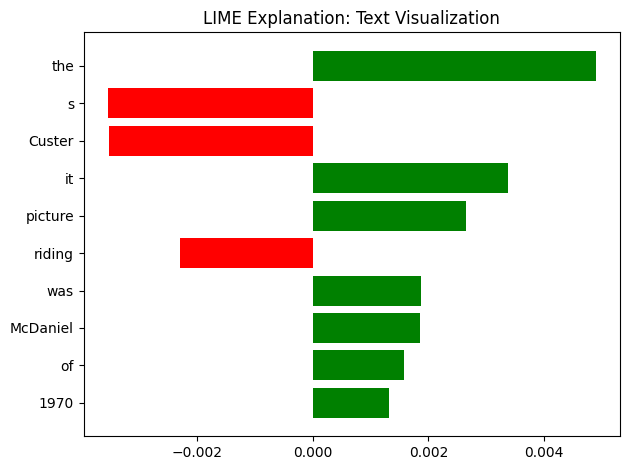


Prediction probabilities:
negative: 0.4682
neutral: 0.5318

--------------------------------------------------

Review 2:

Analyzing review: Pepe le Moko, played by Charles Boyer, is some sort of international criminal mastermind wanted in c...


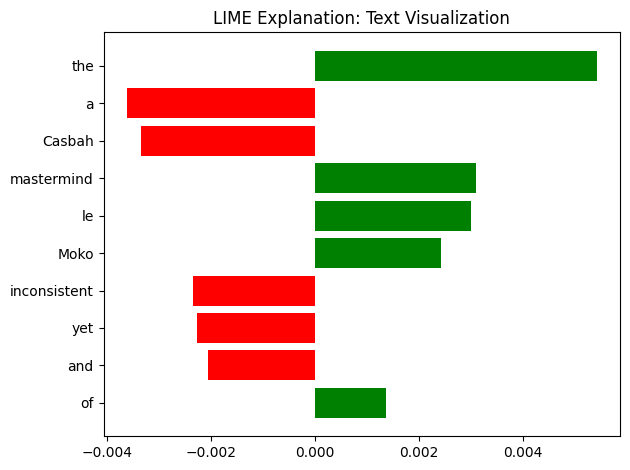


Prediction probabilities:
negative: 0.4750
neutral: 0.5250

--------------------------------------------------

Review 3:

Analyzing review: One of the most significant quotes from the entire film is pronounced halfway through by the protago...


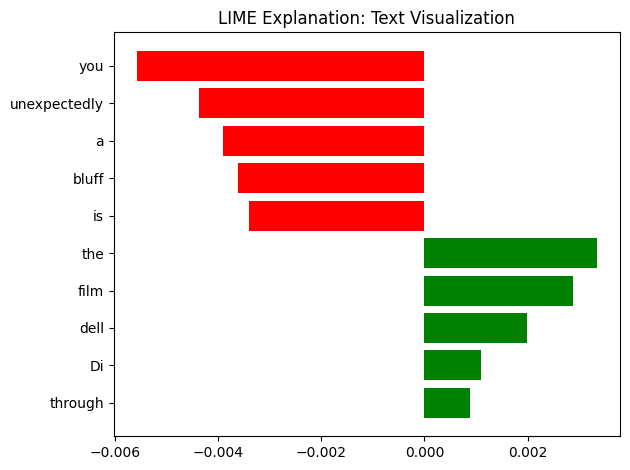


Prediction probabilities:
negative: 0.4905
neutral: 0.5095

--------------------------------------------------

Review 4:

Analyzing review: I just started watching The Show around July. I found it by mistake, I was channel surfing during a ...


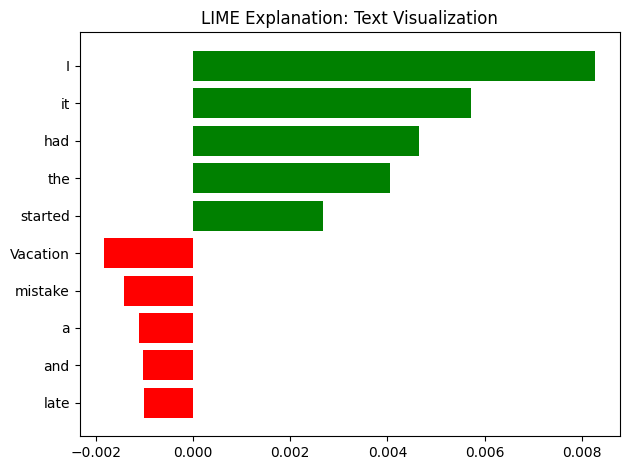


Prediction probabilities:
negative: 0.4214
neutral: 0.5786

--------------------------------------------------

Review 5:

Analyzing review: If anyone is wondering why no one makes movies like they used to, with conversation, character and a...


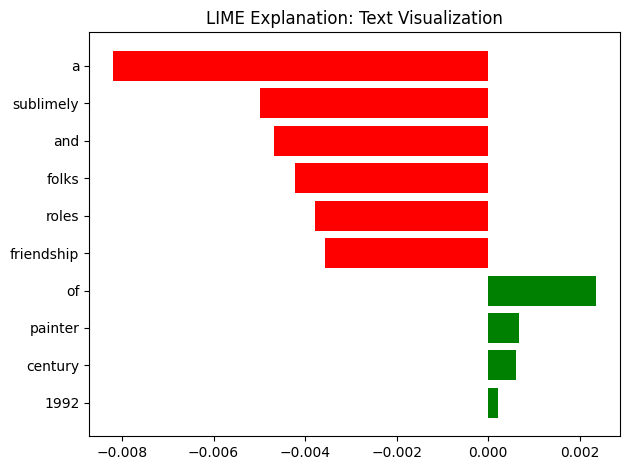


Prediction probabilities:
negative: 0.4810
neutral: 0.5190

--------------------------------------------------


In [36]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import chardet

def detect_file_encoding(filename):
    """Detect the file encoding using chardet"""
    with open(filename, 'rb') as file:
        raw_data = file.read()
    result = chardet.detect(raw_data)
    return result['encoding']

def read_conll_data(filename):
    """Read CoNLL format file and convert to sentence format with encoding detection."""
    try:
        # First try to detect the encoding
        encoding = detect_file_encoding(filename)
        print(f"Detected file encoding: {encoding}")

        # If detection failed, try common encodings
        if not encoding:
            encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
        else:
            encodings_to_try = [encoding]

        # Try different encodings
        for enc in encodings_to_try:
            try:
                sentences = []
                current_sentence = []
                current_labels = []

                print(f"Trying to read file with {enc} encoding...")
                with open(filename, 'r', encoding=enc) as f:
                    for line in f:
                        line = line.strip()
                        if line:  # If line is not empty
                            try:
                                token, label = line.split()
                                current_sentence.append(token)
                                current_labels.append(label)
                            except ValueError as e:
                                print(f"Warning: Skipping malformed line: {line}")
                                continue
                        elif current_sentence:  # If line is empty and we have a sentence
                            sentences.append({
                                'text': ' '.join(current_sentence),
                                'tokens': current_sentence.copy(),
                                'labels': current_labels.copy()
                            })
                            current_sentence = []
                            current_labels = []

                # Add the last sentence if file doesn't end with empty line
                if current_sentence:
                    sentences.append({
                        'text': ' '.join(current_sentence),
                        'tokens': current_sentence,
                        'labels': current_labels
                    })

                print(f"Successfully read {len(sentences)} sentences from the file")
                return sentences

            except UnicodeDecodeError:
                print(f"Failed to read with {enc} encoding, trying next...")
                continue

        raise ValueError("Failed to read file with any encoding")

    except Exception as e:
        print(f"Error reading file: {str(e)}")
        return []

class ReviewExplainer:
    def __init__(self, model_name="distilbert-base-cased"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        print("Loading tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        print("Loading model...")
        self.model = AutoModelForTokenClassification.from_pretrained(model_name)
        self.model.to(self.device)

        print("Initializing LIME explainer...")
        self.lime_explainer = LimeTextExplainer(class_names=['negative', 'neutral', 'positive'])

    def predict_proba(self, texts):
        """Prediction function for LIME"""
        self.model.eval()
        probabilities = []

        with torch.no_grad():
            for text in texts:
                try:
                    inputs = self.tokenizer(text,
                                          return_tensors="pt",
                                          padding=True,
                                          truncation=True,
                                          max_length=512).to(self.device)

                    outputs = self.model(**inputs)
                    logits = outputs.logits

                    # Average the predictions across tokens
                    probs = torch.softmax(logits, dim=-1).mean(dim=1)
                    probabilities.append(probs.cpu().numpy()[0])
                except Exception as e:
                    print(f"Error processing text: {str(e)}")
                    probabilities.append(np.zeros(3))  # Default to zero probabilities

        return np.array(probabilities)

    def explain_review(self, text, num_features=10):
        """Generate and visualize LIME explanation for a review"""
        print(f"\nAnalyzing review: {text[:100]}...")

        try:
            # Generate LIME explanation
            exp = self.lime_explainer.explain_instance(
                text,
                self.predict_proba,
                num_features=num_features,
                top_labels=1
            )

            # Get the explanation for the top predicted class
            top_label = exp.available_labels()[0]

            # Plot 2: Text visualization with highlighted words
            exp.as_pyplot_figure(label=top_label)
            plt.title('LIME Explanation: Text Visualization')
            plt.tight_layout()
            plt.show()

            return exp

        except Exception as e:
            print(f"Error generating explanation: {e}")
            return None

def analyze_reviews():
    # First install chardet if not already installed
    try:
        import chardet
    except ImportError:
        print("Installing chardet package...")
        !pip install chardet
        import chardet

    print("Reading CoNLL data...")
    sentences = read_conll_data("reviews_conll.txt")

    if not sentences:
        print("No sentences were read from the file. Exiting...")
        return

    print(f"Total number of sentences: {len(sentences)}")

    # Split into train and test
    train_data, test_data = train_test_split(sentences, test_size=0.2, random_state=42)

    # Initialize explainer
    print("Initializing explainer...")
    explainer = ReviewExplainer()

    # Analyze some test reviews
    print(f"\nAnalyzing {min(5, len(test_data))} test reviews...")
    for i, review in enumerate(test_data[:5]):
        print(f"\nReview {i+1}:")
        print("=" * 50)
        exp = explainer.explain_review(review['text'])

        if exp:
            print("\nPrediction probabilities:")
            probs = explainer.predict_proba([review['text']])[0]
            for label, prob in zip(['negative', 'neutral', 'positive'], probs):
                print(f"{label}: {prob:.4f}")

            print("\n" + "-" * 50)

if __name__ == "__main__":
    analyze_reviews()
